[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1m-6bOVI-F-3YtMilgrJN5ndeuDOvLkCZ?usp=sharing)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from scipy.special import softmax
from sklearn.metrics import confusion_matrix
import autograd.numpy as npy
from autograd import grad
from autograd import elementwise_grad

In [ ]:
class LogisticRegression():
    def __init__(self, fit_intercept=True):
        '''
        :param fit_intercept: Whether to calculate the intercept for this model. If set to False, no intercept will be used in calculations (i.e. data is expected to be centered).
        '''
        self.fit_intercept = fit_intercept
        self.coef_ = None #Replace with numpy array or pandas series of coefficients learned using using the fit methods
        self.thetas = [] 
        self.costs = []
        self.X = None
        self.y = None

        pass

    def fit(self, X, y, n_iter=1000, lr=0.01, lr_type='constant'):

        if isinstance(X,pd.DataFrame):
            X = X.to_numpy()
        
        if isinstance(y,pd.Series):
            y = y.to_numpy()

        m = X.shape[1] 

        y1 = np.eye(len(np.unique(y)))[y]
        n =  y1.shape[1]

        if self.fit_intercept == True:
            theta = np.random.randn(m+1,n)
            X0 = np.ones((X.shape[0],1))
            X = np.append(X0,X,axis = 1)
        elif self.fit_intercept == False:
            theta = np.random.randn(m,n)

        self.X = X
        self.y = y1
        
        for it in range(1,n_iter+1):
            if lr_type == 'constant':
                c = 1
            elif lr_type == 'inverse':
                c = 1/(it+1)

            Z = np.dot(X,theta)
            # print(X.shape,theta.shape,Z.shape)

            y_hat = softmax(Z,axis=1)
            dtheta = (1/n)*np.dot( X.T,y_hat-y1) 
            theta = theta - c*lr*dtheta

            # Keeping track of our weights
            self.thetas.append(theta)
            
        self.coef_ = theta
        
        return

    def cost(self,theta): 
        X = self.X
        y = self.y
        cost = 0
        for i in range(X.shape[0]):
            k = npy.argmax(y[i])
            zi = npy.dot(X[i],theta)
            cost -= npy.log(npy.exp(npy.dot(X[i],theta[:,k]))/npy.sum(npy.exp(zi)))

        cost = cost/len(y)
        return cost


    def fit_autograd(self, X, y, n_iter=1000, lr=0.01, lr_type='constant'):

        if isinstance(X,pd.DataFrame):
            X = X.to_numpy()
        
        if isinstance(y,pd.Series):
            y = y.to_numpy()

        m = X.shape[1] 
        y1 = np.eye(len(np.unique(y)))[y]

        n =  y1.shape[1]

        if self.fit_intercept == True:
            theta = np.random.randn(m+1,n)
            X0 = np.ones((X.shape[0],1))
            X = np.append(X0,X,axis = 1)
        elif self.fit_intercept == False:
            theta = np.random.randn(m,n)

        self.X = X
        self.y = y1

        ag = elementwise_grad(self.cost)
        for it in range(1,n_iter+1):
            if lr_type == 'constant':
                c = 1
            elif lr_type == 'inverse':
                c = 1/(it+1)

            cost = ag(theta)
            
            theta -= c*lr*cost

            # Keeping track of our weights
            self.thetas.append(theta)
            
            # Keeping track of our cost function value
            self.costs.append(cost)
            # if(it%50 == 0):
            #     print("cost after ", it, "iteration is : ", cost)

        self.coef_ = theta
        return

    
    def predict(self, X):
            
        if isinstance(X,pd.DataFrame):
            X = X.to_numpy()

        if self.fit_intercept == True:  
            m = X.shape[0]
            X0 = np.ones((m,1))
            X = np.append(X0,X,axis = 1)
        
        Z = np.dot(X,self.coef_)
        y_hat = softmax(Z,axis=1)
        y_hat = np.argmax(y_hat, axis=1)
        return pd.Series(y_hat)

    def accuracy(self,y_hat,y):

        assert(y_hat.size == y.size)
        true_pred = 0
        for i in range(y_hat.size):
            if y_hat[i]==y[i]:
                true_pred+=1

        accu = true_pred/y.size
        return accu*100


### Dataset Preprocessing

In [ ]:
digits = load_digits()
X = pd.DataFrame(digits.data)
y = pd.Series(digits['target'])

### Part - a

In [ ]:
def q_a(X,y):
    X = X.to_numpy()
    y = y.to_numpy()
    LR = LogisticRegression()
    LR.fit(X,y)
    pred = LR.predict(X)
    print("\nPart a:")
    print("Accuracy: ",LR.accuracy(pred,y))
    return

q_a(X,y)


Part a:
Accuracy:  100.0


### Part - b

In [ ]:
def q_b(X,y):
    X = X.to_numpy()
    y = y.to_numpy()
    LR = LogisticRegression()
    LR.fit_autograd(X,y)
    pred = LR.predict(X)
    print("\nPart b:")
    print("Accuracy: ",LR.accuracy(pred,y))
    return

q_b(X,y)


Part b:
Accuracy:  92.7657206455203


### Part - c

In [ ]:
def q_c(X,y):
    X = X.to_numpy()
    y = y.to_numpy()
    uni = len(np.unique(y))
    print("\nPart c:")
    cnt = 1
    accu = []
    wrong = np.zeros((uni,uni))
    ACC = np.zeros(uni)
    kf = StratifiedKFold(n_splits=4,shuffle=True)
    for train_index, test_index in kf.split(X,y):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        LR = LogisticRegression()
        LR.fit(X_train,y_train)
        pred = LR.predict(X_test)
        accu.append(LR.accuracy(pred,y_test))
        print(cnt,". Accuracy: ",accu[cnt-1])
        confusion = confusion_matrix(y_test, pred)
        print('\nConfusion Matrix:\n')
        print(confusion,"\n")
        for i in range(10):
            for j in range(10):
                if i!=j:
                    wrong[i][j] += confusion[i][j] + confusion[j][i]
                    wrong[j][i] += confusion[i][j] + confusion[j][i]
            ACC[i] += confusion[i][i]/np.sum(confusion[:,i])
        cnt+=1

    print("Overall/Average Accuracy: ",sum(accu)/len(accu))
    print("Digit which get confused most : ", np.argmax(wrong))
    print("Digit which is easiest to predict: ", np.argmax(ACC))


q_c(X,y)


Part c:
1 . Accuracy:  95.55555555555556

Confusion Matrix:

[[45  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  1  0  0  1  0  1  1]
 [ 0  0 45  0  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  1  0  1]
 [ 0  0  0  0 45  0  1  0  0  0]
 [ 0  0  0  1  0 41  1  1  0  1]
 [ 0  0  0  0  0  0 45  0  0  0]
 [ 0  0  0  0  0  0  0 45  0  0]
 [ 0  2  1  2  0  0  0  2 37  0]
 [ 0  0  0  1  0  1  0  0  0 43]] 

2 . Accuracy:  94.87750556792874

Confusion Matrix:

[[45  0  0  0  0  0  0  0  0  0]
 [ 0 44  0  0  1  0  0  0  0  0]
 [ 1  1 39  3  0  0  0  0  0  0]
 [ 0  0  0 42  0  0  0  0  4  0]
 [ 0  0  0  0 41  0  0  1  2  1]
 [ 0  0  0  0  1 45  0  0  0  0]
 [ 0  0  0  0  0  1 44  0  0  0]
 [ 0  0  0  0  0  0  0 43  1  1]
 [ 0  0  0  0  0  1  0  0 42  0]
 [ 0  1  0  1  0  0  0  0  2 41]] 

3 . Accuracy:  96.43652561247215

Confusion Matrix:

[[43  0  0  0  1  0  0  0  0  0]
 [ 0 45  0  0  0  0  1  0  0  0]
 [ 0  0 43  0  0  0  0  1  0  0]
 [ 0  0  0 45  0  0  0  0  1  0]
 [ 1  1  0  0 42  0  1  0  0  0]
 

### Part - d

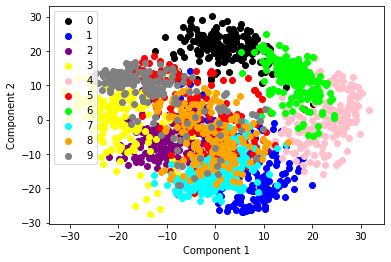

In [ ]:
def q_d(X):
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    colors = ['black', 'blue', 'purple', 'yellow', 'pink', 'red', 'lime', 'cyan', 'orange', 'gray']
    for i in range(len(colors)):
        px = X_pca[:, 0][y == i]
        py = X_pca[:, 1][y == i]
        plt.scatter(px, py, c=colors[i])
    plt.legend(digits.target_names)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.show()
    return

q_d(X)